# Updates

In [1]:
from bokeh.io import output_notebook
output_notebook()

Loading BokehJS ...

In [2]:
%load_ext autoreload
%autoreload 2

In [3]:
import os
os.environ["DJANGO_ALLOW_ASYNC_UNSAFE"] = "true"

In [4]:
from casestudy.covidcharts import tweetledee

In [5]:
# print ('Instantiate Exception Logger')
# filename = 'twitter-{}.log'.format(dt.now().strftime('%Y-%m-%d'))
# logfile = config('TWEETLOG_PATH') + filename
# exc_logger = ExceptionLogger(logfile)

In [6]:
def wrap(self, level='exception'):
    """
    Decorator for catching and logging exceptions for whatever function is called
    Applied using traditional syntax of func = exc_wrap(level)(func)
    """
    assert level in ['exception', 'critical']

    def decorator(func):                
        @functools.wraps(func)
        def log_exception(*args, **kwargs):

            try:
                result = func(*args, **kwargs)
                return result
            except Exception as e:
                print (repr(e))
                if level == 'exception':
                    logging.exception(func.__name__ + str(e))
                elif level == 'critical':
                    logging.critical(func.__name__ + str(e))
        return log_exception
    return decorator

In [7]:
from datetime import datetime as dt, timedelta
import pandas as pd
from decouple import config

from see19 import CaseStudy, get_baseframe
from see19.constants import COUNT_TYPES

from casestudy.update.helpers import ExceptionLogger
from casestudy.covidcharts.tweetbot import TweetBot

print ('Getting See19 Baseframe')
baseframe = get_baseframe()

live = config('TWEETBOT_LIVE', cast=bool)

print ('Instantiate Exception Logger')
filename = 'twitter-{}.log'.format(dt.now().strftime('%Y-%m-%d'))
logfile = config('TWEETLOG_PATH') + filename
exc_logger = ExceptionLogger(logfile)

## Load CaseStudy
countries = [
    'United States of America (the)',
    'Brazil', 
    'Australia', 
    'Japan', 
    'Singapore', 
    'Taiwan',  
    'Korea (the Republic of)',
    'Hong Kong', 
    'Malaysia',
    'Canada', 'Italy',
    'Germany', 
    'Sweden',
    'United Kingdom of Great Britain and Northern Ireland (the)',
    'France', 
    'Norway',  
    'Spain', 
    'Denmark', 
    'Finland',
]

factors_with_dmas = ['strindex']
factor_dmas = {factor: 28 for factor in factors_with_dmas}
mobi_dmas = {factor: 1 for factor in [*CaseStudy.GMOBIS, *CaseStudy.AMOBIS]}
factors = factors_with_dmas + CaseStudy.GMOBIS + ['A65PLUSB'] + CaseStudy.AMOBIS

print ('Instantiate casestudy')
casestudy = CaseStudy(
    baseframe, countries=countries, count_dma=3, factors=factors, 
    factor_dmas=factor_dmas, mobi_dmas=mobi_dmas, start_hurdle=dt(2020,3,1), start_factor='date', lognat=True,
    min_deaths=1,
)

# instantiate TweetBot instance
print ('Instantiate TweetBot')
tweetbot = TweetBot(live=live, wait=live, wait_time=1)

Getting See19 Baseframe
Instantiate Exception Logger***********************] Downloading ... COMPLETE
Instantiate casestudy
Instantiate TweetBot


In [8]:
### CASE AND FATALITY COMPARISONS ###
region_groups = [
    ['Texas', 'Alabama', 'Arizona'],
    ['Georgia', 'Tennessee', 'Florida'],
    ['California', 'Florida', 'Washington'],
    ['Illinois', 'Ohio', 'Massachusetts'], 
    ['British Columbia', 'Ontario', 'New South Wales'],
    ['Sweden', 'Norway', 'Finland', 'Denmark'],
    ['Spain', 'Germany', 'France'],
    ['Lombardia', 'New York', 'New Jersey'],
    ['Sao Paulo', 'Rio De Janeiro'],
    ['Hong Kong', 'Singapore'],
    ['Japan', 'Malaysia', 'Korea, South']

]
print ('Creating Case and Fatality comparisons for ...')
for regions in region_groups:
    print ('\t' + ' '.join(regions))
    for count_type in ['cases', 'deaths']:
        wrapped_chart = exc_logger.wrap()(tweetbot.count_comparison)
        wrapped_chart(casestudy, count_type, regions)

    wrapped_chart = exc_logger.wrap()(tweetbot.amobi_comparison)
    wrapped_chart(casestudy, regions)

    status = """
        Change in Apple Mobility Index (driving) along with New Case and Fatality updates for {}
    """.format(' & '.join(regions))

    wrapped_tweet = exc_logger.wrap(tweetbot.new_tweet)
    wrapped_tweet(status)

Creating Case and Fatality comparisons for ...
	Texas Alabama Arizona


	Georgia Tennessee Florida


	California Florida Washington


	Illinois Ohio Massachusetts


	British Columbia Ontario New South Wales


	Sweden Norway Finland Denmark


	Spain Germany France


	Lombardia New York New Jersey


	Sao Paulo Rio De Janeiro


	Hong Kong Singapore


	Japan Malaysia Korea, South


In [ ]:
### WAVE ANALYSIS ###
print ('Creating Wave Analysis for ..')
df_ex = casestudy.df[casestudy.df.country_code != 'BRA']
df_braz = casestudy.df[casestudy.df.country_code == 'BRA']
dfs = {'ex_BRA': df_ex, 'BRA': df_braz}

for key, df in dfs.items():
    for count_type in ['cases', 'deaths']:
        comp_category = count_type + '_new_dma_per_1M'
        wrappedfinder = exc_logger.wrap()(tweetbot.wavefinder)
        wave_types, regions_str, end_date = wrappedfinder(df, comp_category, key)

        for wave_type, regions in wave_types.items():
            print ('\t' + key + ': ' + wave_type)
            title = ' '.join(wave_type.split('_')).title() + 's' + ' for {} - {}'.format(regions_str, end_date.strftime('%b %d'))

            if len(regions) == 0:
                pass
            if len(regions) <= 4 and len(regions) > 0:
                wrapped_chart = exc_logger.wrap()(tweetbot.multiline_comparison)
                wrapped_chart(casestudy, comp_category, regions, title)

            elif len(regions) > 4 and len(regions) <= 20:
                wrapped_chart = exc_logger.wrap(tweetbot.scatterflow)
                wrapped_chart(casestudy, comp_category, regions, title)

        num_regions = df.region_name.unique().shape[0]
        status = """
        Wave Update for New {}. Out of {} regions in {}, {} regions are experiencing a weak wave, {} are experiencing a sustained wave, and {} peaking. 
        """.format(
            count_type.capitalize(), num_regions, regions_str,
            len(wave_types['weak_wave']), 
            len(wave_types['sustained_wave']), 
                   str(len(wave_types['peak_wave'])) + ' is' if len(wave_types['peak_wave']) == 1 else str(len(wave_types['peak_wave'])) + ' are'
        )
        print (status)
        wrapped_tweet = exc_logger.wrap(tweetbot.new_tweet)
        wrapped_tweet(status)

In [46]:
# instantiate TweetBot instance
print ('Instantiate TweetBot')
tweetbot = TweetBot(live=True, wait=False, wait_time=1)

Instantiate TweetBot


Instantiating US CaseStudy
Printing Positivity Bar ...


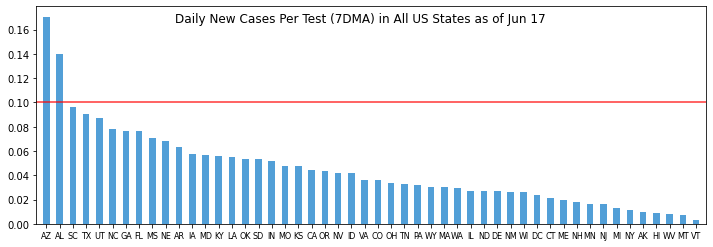

In [47]:
### US POSITIVITY RATIO ###
print ('Instantiating US CaseStudy')
cs_usa = CaseStudy(
    baseframe, countries='United States of America (the)',
    start_hurdle=dt(2020,4,26), start_factor='date', count_dma=7,
    min_deaths=1,
)

print ('Printing Positivity Bar ...')
wrapped_chart = exc_logger.wrap(tweetbot.positivity_bar)
wrapped_chart(cs_usa)

In [48]:
status = """Testing efficiency across the US #COVID19 #COVID #Covid19usa #coronavirus #c19
"""
wrapped_tweet = exc_logger.wrap(tweetbot.new_tweet)
wrapped_tweet(status)

Making Positivity Race ...


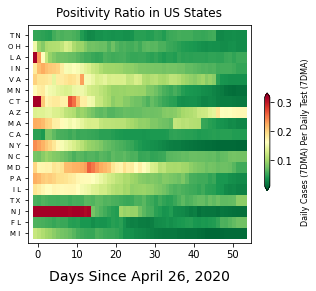

In [49]:
print ('Making Positivity Race ...')
wrapped_chart = exc_logger.wrap(tweetbot.positivity_race)
wrapped_chart(cs_usa)

In [50]:
status = """Positivity ratio in the most impacted US states in the past month  #covid19 #covid #c19 #coronavirus
    """
wrapped_tweet = exc_logger.wrap(tweetbot.new_tweet)
wrapped_tweet(status)

Instantiate country level CaseStudy for Strindex
Printing Global strindex race


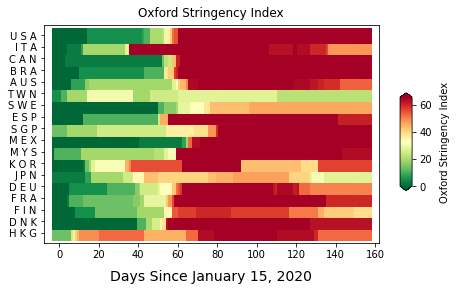

In [51]:
### Country Level CaseStudy for Strindex ###
print ('Instantiate country level CaseStudy for Strindex')
factors_with_dmas = CaseStudy.STRINDEX_CATS
factor_dmas = {factor: 5 for factor in factors_with_dmas}
factors = factors_with_dmas + ['A65PLUSB']
countries = [
    'United States of America (the)', 'Japan', 'Korea (the Republic of)', 
    'Hong Kong', 'Australia', 'Taiwan (Province of China)',
    'Canada', 'Mexico', 'Brazil', 'Spain', 'Germany', 'Italy', 'France',
    'Malaysia', 'Singapore', 'Denmark', 'Sweden', 'Finland', 
]
excluded_regions = ['Saint Pierre and Miquelon', 'Saint Barthelemy', 'Reunion', 'New Caledonia', 'Greenland',
    'French Polynesia', 'French Guiana', 'Faroe Islands',
]

casestudy = CaseStudy(
    baseframe, countries=countries, excluded_regions=excluded_regions, count_dma=3, factors=factors, 
    factor_dmas=factor_dmas, start_hurdle=dt(2020,1,15), start_factor='date', lognat=True,
    min_deaths=1, country_level=True,
)

print ('Printing Global strindex race')
wrapped_chart = exc_logger.wrap(tweetbot.strindex_race)
wrapped_chart(casestudy)

In [52]:
status = """Lighter shading towards the right of the graph shows the relaxing of quarantine in some countries #covid19 #covid #c19 #coronavirus
"""
wrapped_tweet = exc_logger.wrap(tweetbot.new_tweet)
wrapped_tweet(status)

print ('All Tweets Complete!!!')


All Tweets Complete!!!
